In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

---

In [ ]:
import os 
from datetime import date
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import pandas as pd
import json

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import numpy.random as random
from src.datasets.data import SPReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

In [ ]:
from src.models.ts_transformer import RelativeGlobalAttention
from src.utils.losses import *
from src.utils.analysis import action_evaluator

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "model_params":{
        "linear_filters":[1024,1024,1024,2048],
        "input_feat":36,
        "dropout":0.1,
    },
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 64,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = SPReader(IMU_data_path)
actionList = dataReader.idToLabel

In [ ]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [ ]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [ ]:
emb = model(torch.randn((32,36)))
emb.size()

torch.Size([32, 2048])

In [ ]:
emb

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0776],
        [1.8329, 0.0045, 0.9750,  ..., 0.4087, 0.0000, 0.7254],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7942, 0.9069],
        ...,
        [0.0225, 0.0000, 0.0000,  ..., 0.3112, 0.0000, 0.0000],
        [1.0676, 0.0000, 1.0517,  ..., 0.0000, 0.0000, 0.1474],
        [0.2466, 0.0000, 0.0000,  ..., 0.0000, 0.0829, 0.0000]],
       grad_fn=<ReluBackward0>)

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/feat_dict_2048.npz'
video_data = np.load(I3D_data_path)
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
video_feat.shape

(180, 2048)

In [ ]:
vid_cls_name = np.unique(video_classes)

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [ ]:
selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

torch.Size([18, 2048])

In [ ]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [ ]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((16752, 26, 54), (4189, 26, 54), (5608, 26, 54))

In [ ]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

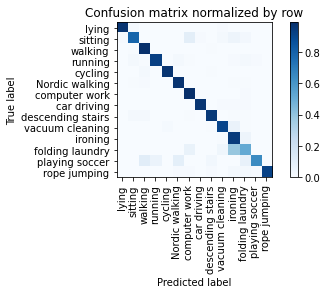

Overall accuracy: 0.918

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.917      0.987      0.951      0.148        614|	 folding laundry: 0.008,	vacuum cleaning: 0.003,	
          walking       0.955      0.986      0.970      0.118        491|	 descending stairs: 0.006,	sitting: 0.006,	
          ironing       0.785      0.942      0.856      0.115        480|	 folding laundry: 0.048,	vacuum cleaning: 0.006,	
   Nordic walking       0.971      0.971      0.971      0.093        385|	 walking: 0.010,	folding laundry: 0.005,	
            lying       0.989      0.964      0.976      0.088        365|	 sitting: 0.016,	vacuum cleaning: 0.011,	
          sitting       0.933      0.784      0.852      0.086        357|	 computer work: 0.098,	ironing: 0.048,	
  vacuum cleaning       0.928      0.906      0.917      0.082        340|	 ironing: 0.065,	cycling: 0.015,	
          cycling       0.984      0.965      0.974    

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

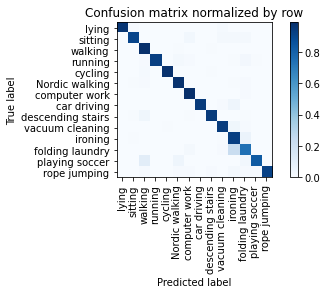

Overall accuracy: 0.944

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.968      0.985      0.977      0.147        612|	 folding laundry: 0.008,	vacuum cleaning: 0.003,	
          walking       0.947      0.988      0.967      0.118        491|	 Nordic walking: 0.006,	descending stairs: 0.004,	
          ironing       0.854      0.929      0.890      0.115        480|	 folding laundry: 0.058,	vacuum cleaning: 0.006,	
   Nordic walking       0.974      0.974      0.974      0.093        386|	 folding laundry: 0.008,	walking: 0.008,	
            lying       1.000      0.964      0.982      0.088        365|	 vacuum cleaning: 0.014,	sitting: 0.011,	
          sitting       0.967      0.905      0.935      0.086        357|	 computer work: 0.028,	ironing: 0.022,	
  vacuum cleaning       0.936      0.941      0.938      0.082        340|	 ironing: 0.038,	folding laundry: 0.009,	
          cycling       0.994      0.978

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

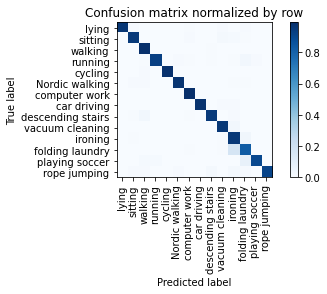

Overall accuracy: 0.960

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.987      0.990      0.989      0.148        614|	 folding laundry: 0.003,	vacuum cleaning: 0.003,	
          walking       0.970      0.992      0.981      0.118        490|	 descending stairs: 0.006,	sitting: 0.002,	
          ironing       0.889      0.954      0.920      0.115        477|	 folding laundry: 0.034,	vacuum cleaning: 0.006,	
   Nordic walking       0.992      0.972      0.982      0.093        386|	 sitting: 0.010,	walking: 0.008,	
            lying       1.000      0.965      0.982      0.088        368|	 sitting: 0.011,	folding laundry: 0.008,	
          sitting       0.955      0.950      0.952      0.086        357|	 vacuum cleaning: 0.022,	ironing: 0.014,	
  vacuum cleaning       0.948      0.959      0.953      0.082        341|	 ironing: 0.029,	folding laundry: 0.003,	
          cycling       0.997      0.981      0.989  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

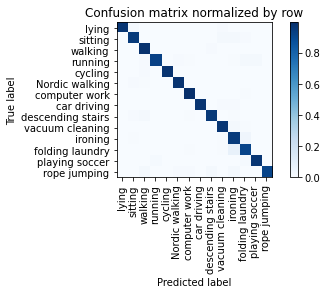

Overall accuracy: 0.965

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.993      0.991      0.147        612|	 folding laundry: 0.005,	vacuum cleaning: 0.002,	
          walking       0.972      0.986      0.979      0.117        487|	 descending stairs: 0.010,	ironing: 0.002,	
          ironing       0.931      0.950      0.940      0.116        482|	 folding laundry: 0.039,	vacuum cleaning: 0.006,	
   Nordic walking       0.992      0.974      0.983      0.093        386|	 sitting: 0.010,	walking: 0.005,	
            lying       1.000      0.967      0.983      0.088        367|	 sitting: 0.019,	vacuum cleaning: 0.008,	
          sitting       0.950      0.950      0.950      0.086        358|	 vacuum cleaning: 0.020,	ironing: 0.017,	
  vacuum cleaning       0.951      0.968      0.959      0.081        339|	 ironing: 0.018,	folding laundry: 0.006,	
          cycling       0.997      0.978      0.987  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

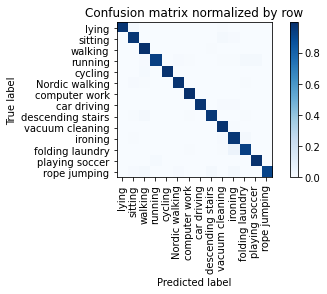

Overall accuracy: 0.972

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.148        616|	 sitting: 0.003,	folding laundry: 0.002,	
          walking       0.970      0.994      0.982      0.118        491|	 descending stairs: 0.004,	sitting: 0.002,	
          ironing       0.954      0.964      0.959      0.115        478|	 folding laundry: 0.023,	vacuum cleaning: 0.008,	
   Nordic walking       0.992      0.977      0.984      0.092        384|	 sitting: 0.008,	folding laundry: 0.005,	
            lying       1.000      0.967      0.983      0.088        365|	 sitting: 0.022,	vacuum cleaning: 0.005,	
          sitting       0.945      0.964      0.954      0.086        358|	 vacuum cleaning: 0.020,	ironing: 0.008,	
  vacuum cleaning       0.948      0.982      0.965      0.081        337|	 ironing: 0.006,	folding laundry: 0.003,	
          cycling       0.993      0.981      0.987  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

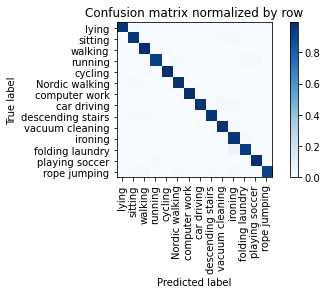

Overall accuracy: 0.974

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.147        612|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.982      0.992      0.987      0.118        490|	 descending stairs: 0.006,	sitting: 0.002,	
          ironing       0.943      0.973      0.958      0.115        479|	 folding laundry: 0.021,	vacuum cleaning: 0.006,	
   Nordic walking       0.992      0.979      0.986      0.093        386|	 sitting: 0.008,	walking: 0.005,	
            lying       1.000      0.967      0.983      0.088        368|	 sitting: 0.022,	vacuum cleaning: 0.005,	
          sitting       0.950      0.961      0.955      0.086        357|	 ironing: 0.017,	vacuum cleaning: 0.014,	
  vacuum cleaning       0.962      0.979      0.971      0.082        340|	 ironing: 0.012,	folding laundry: 0.003,	
          cycling       0.993      0.987      0.990      0.07

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

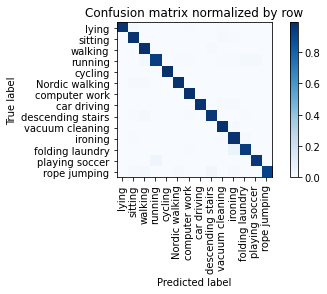

Overall accuracy: 0.974

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.147        613|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.974      0.988      0.981      0.118        489|	 descending stairs: 0.012,	rope jumping: 0.000,	
          ironing       0.957      0.975      0.966      0.116        482|	 folding laundry: 0.015,	vacuum cleaning: 0.006,	
   Nordic walking       0.995      0.977      0.986      0.093        385|	 sitting: 0.010,	walking: 0.008,	
            lying       1.000      0.967      0.983      0.088        367|	 sitting: 0.016,	vacuum cleaning: 0.005,	
          sitting       0.953      0.975      0.964      0.086        357|	 vacuum cleaning: 0.014,	ironing: 0.006,	
  vacuum cleaning       0.960      0.982      0.971      0.082        340|	 ironing: 0.012,	cycling: 0.003,	
          cycling       0.994      0.987      0.990      0.075  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

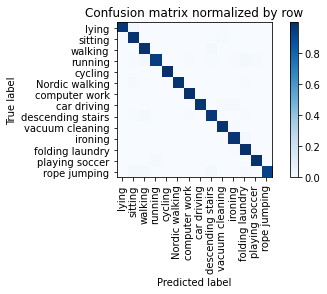

Overall accuracy: 0.977

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.997      0.992      0.994      0.148        614|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.978      0.982      0.980      0.118        490|	 descending stairs: 0.016,	sitting: 0.002,	
          ironing       0.983      0.975      0.979      0.115        480|	 folding laundry: 0.019,	vacuum cleaning: 0.006,	
   Nordic walking       1.000      0.977      0.988      0.093        385|	 sitting: 0.010,	folding laundry: 0.005,	
            lying       1.000      0.967      0.983      0.087        362|	 sitting: 0.025,	vacuum cleaning: 0.006,	
          sitting       0.946      0.978      0.962      0.086        358|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.965      0.982      0.974      0.081        339|	 ironing: 0.009,	folding laundry: 0.003,	
          cycling       0.994      0.987     

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

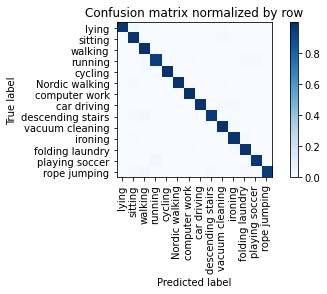

Overall accuracy: 0.980

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.995      0.993      0.994      0.148        614|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.974      0.998      0.986      0.118        489|	 descending stairs: 0.002,	rope jumping: 0.000,	
          ironing       0.975      0.975      0.975      0.115        479|	 folding laundry: 0.015,	vacuum cleaning: 0.006,	
   Nordic walking       0.997      0.979      0.988      0.093        385|	 sitting: 0.010,	vacuum cleaning: 0.005,	
            lying       1.000      0.967      0.983      0.088        365|	 sitting: 0.022,	vacuum cleaning: 0.005,	
          sitting       0.944      0.980      0.962      0.086        358|	 vacuum cleaning: 0.011,	ironing: 0.006,	
  vacuum cleaning       0.963      0.985      0.974      0.081        339|	 ironing: 0.009,	descending stairs: 0.003,	
          cycling       1.000      0.987      

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

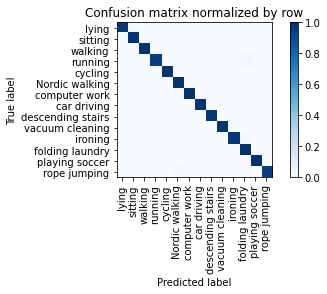

Overall accuracy: 0.979

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.994      0.994      0.994      0.149        618|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.988      0.992      0.990      0.118        492|	 descending stairs: 0.008,	rope jumping: 0.000,	
          ironing       0.979      0.971      0.975      0.116        482|	 folding laundry: 0.023,	vacuum cleaning: 0.006,	
   Nordic walking       0.995      0.977      0.986      0.093        386|	 sitting: 0.010,	folding laundry: 0.005,	
            lying       1.000      0.967      0.983      0.088        365|	 sitting: 0.016,	vacuum cleaning: 0.005,	
          sitting       0.958      0.977      0.968      0.085        354|	 vacuum cleaning: 0.011,	ironing: 0.006,	
  vacuum cleaning       0.968      0.982      0.975      0.081        339|	 ironing: 0.012,	folding laundry: 0.003,	
          cycling       1.000      0.987      0.

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

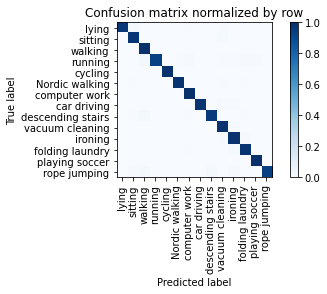

Overall accuracy: 0.980

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.993      0.991      0.148        614|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.976      0.998      0.987      0.117        488|	 descending stairs: 0.002,	rope jumping: 0.000,	
          ironing       0.971      0.985      0.978      0.115        480|	 folding laundry: 0.008,	vacuum cleaning: 0.006,	
   Nordic walking       0.997      0.977      0.987      0.093        386|	 sitting: 0.008,	folding laundry: 0.005,	
            lying       1.000      0.968      0.984      0.089        370|	 sitting: 0.019,	vacuum cleaning: 0.005,	
          sitting       0.961      0.975      0.968      0.086        356|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.960      0.985      0.972      0.082        340|	 ironing: 0.015,	rope jumping: 0.000,	
          cycling       1.000      0.987   

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

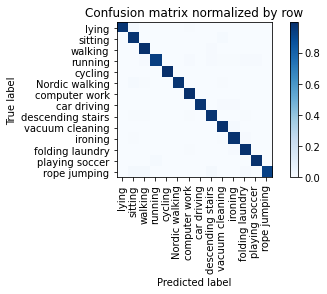

Overall accuracy: 0.980

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.993      0.992      0.147        613|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.984      0.992      0.988      0.118        489|	 descending stairs: 0.008,	rope jumping: 0.000,	
          ironing       0.979      0.981      0.980      0.115        480|	 folding laundry: 0.008,	vacuum cleaning: 0.006,	
   Nordic walking       1.000      0.974      0.987      0.092        383|	 sitting: 0.013,	vacuum cleaning: 0.005,	
            lying       1.000      0.967      0.983      0.088        367|	 sitting: 0.022,	computer work: 0.005,	
          sitting       0.943      0.978      0.960      0.086        358|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.963      0.985      0.974      0.082        340|	 ironing: 0.012,	sitting: 0.003,	
          cycling       1.000      0.990      0.99

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

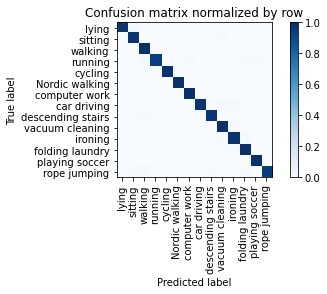

Overall accuracy: 0.982

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.993      0.991      0.147        612|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.980      1.000      0.990      0.118        492|	 rope jumping: 0.000,	playing soccer: 0.000,	
          ironing       0.985      0.983      0.984      0.115        479|	 folding laundry: 0.010,	vacuum cleaning: 0.006,	
   Nordic walking       1.000      0.984      0.992      0.093        386|	 sitting: 0.008,	folding laundry: 0.005,	
            lying       1.000      0.967      0.983      0.088        367|	 sitting: 0.022,	computer work: 0.005,	
          sitting       0.956      0.975      0.965      0.086        357|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.968      0.988      0.978      0.082        341|	 ironing: 0.009,	sitting: 0.003,	
          cycling       1.000      0.987      0.993  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

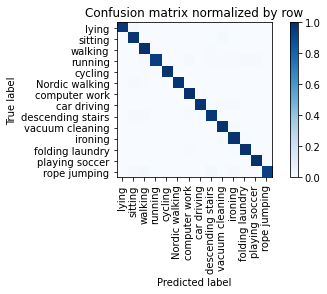

Overall accuracy: 0.982

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.993      0.993      0.147        612|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.980      0.996      0.988      0.118        490|	 descending stairs: 0.004,	rope jumping: 0.000,	
          ironing       0.977      0.985      0.981      0.116        481|	 vacuum cleaning: 0.008,	folding laundry: 0.004,	
   Nordic walking       1.000      0.979      0.990      0.093        387|	 sitting: 0.010,	walking: 0.005,	
            lying       1.000      0.968      0.984      0.089        370|	 sitting: 0.019,	vacuum cleaning: 0.005,	
          sitting       0.951      0.977      0.964      0.085        354|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.960      0.985      0.972      0.081        339|	 ironing: 0.012,	sitting: 0.003,	
          cycling       1.000      0.987      0.994     

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

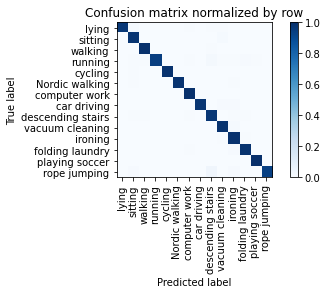

Overall accuracy: 0.982

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.993      0.993      0.147        613|	 folding laundry: 0.003,	ironing: 0.002,	
          walking       0.994      0.994      0.994      0.118        492|	 descending stairs: 0.006,	rope jumping: 0.000,	
          ironing       0.971      0.990      0.980      0.115        479|	 vacuum cleaning: 0.006,	folding laundry: 0.004,	
   Nordic walking       1.000      0.982      0.991      0.093        385|	 sitting: 0.008,	ironing: 0.005,	
            lying       1.000      0.967      0.983      0.087        364|	 sitting: 0.014,	vacuum cleaning: 0.005,	
          sitting       0.961      0.978      0.969      0.086        357|	 vacuum cleaning: 0.014,	folding laundry: 0.003,	
  vacuum cleaning       0.963      0.988      0.975      0.082        341|	 ironing: 0.012,	rope jumping: 0.000,	
          cycling       1.000      0.987      0.994

unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

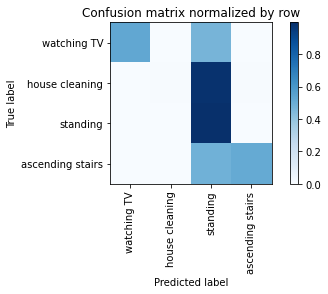

Overall accuracy: 0.508

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.403      0.997      0.574      0.330       1839|	 ascending stairs: 0.003,	house cleaning: 0.000,	
  house cleaning       1.000      0.005      0.011      0.330       1835|	 standing: 0.985,	ascending stairs: 0.007,	
ascending stairs       0.968      0.516      0.673      0.192       1068|	 standing: 0.484,	house cleaning: 0.000,	
     watching TV       0.989      0.529      0.689      0.148        826|	 standing: 0.471,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.795      0.508      0.425 0.9999999999999999       5568|	      

{'accuracy': 0.508441091954023, 'precision': 0.8400440686523134, 'recall': 0.511790060402232, 'f1': 0.4868413704729888}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting'

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

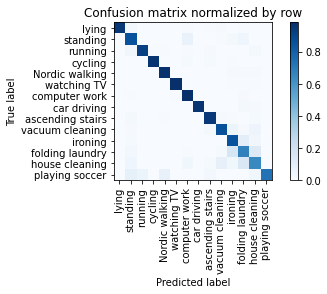

Overall accuracy: 0.890

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.928      0.975      0.951      0.147        612|	 folding laundry: 0.008,	watching TV: 0.005,	
         ironing       0.839      0.857      0.848      0.111        462|	 folding laundry: 0.093,	house cleaning: 0.032,	
  Nordic walking       0.977      0.974      0.976      0.094        390|	 house cleaning: 0.008,	folding laundry: 0.008,	
           lying       1.000      0.948      0.973      0.093        385|	 standing: 0.023,	vacuum cleaning: 0.008,	
        standing       0.836      0.857      0.846      0.087        363|	 computer work: 0.069,	folding laundry: 0.044,	
  house cleaning       0.748      0.646      0.693      0.081        336|	 folding laundry: 0.140,	vacuum cleaning: 0.077,	
         cycling       0.981      0.967      0.974      0.079        329|	 ascending stairs: 0.012,	computer work: 0.012,	
 vacuum cleaning       0.882   

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

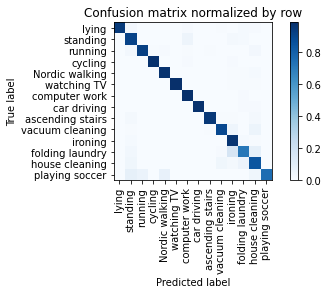

Overall accuracy: 0.928

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.962      0.985      0.973      0.147        612|	 folding laundry: 0.008,	standing: 0.003,	
         ironing       0.863      0.963      0.910      0.110        457|	 folding laundry: 0.015,	standing: 0.015,	
  Nordic walking       0.977      0.972      0.974      0.094        392|	 house cleaning: 0.013,	ironing: 0.008,	
           lying       1.000      0.940      0.969      0.093        386|	 standing: 0.026,	folding laundry: 0.013,	
        standing       0.851      0.912      0.880      0.087        363|	 computer work: 0.047,	ironing: 0.022,	
  house cleaning       0.826      0.843      0.835      0.081        338|	 folding laundry: 0.056,	vacuum cleaning: 0.038,	
         cycling       0.994      0.976      0.985      0.080        332|	 ironing: 0.009,	computer work: 0.009,	
 vacuum cleaning       0.934      0.890      0.911      0.076    

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

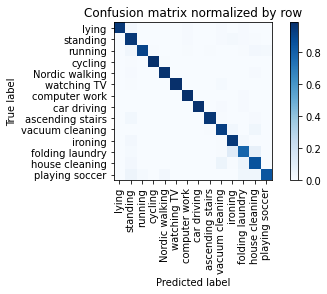

Overall accuracy: 0.940

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.987      0.985      0.986      0.147        610|	 folding laundry: 0.010,	house cleaning: 0.002,	
         ironing       0.907      0.950      0.928      0.111        460|	 standing: 0.026,	folding laundry: 0.020,	
  Nordic walking       0.990      0.972      0.981      0.094        393|	 house cleaning: 0.010,	standing: 0.010,	
           lying       1.000      0.948      0.973      0.093        385|	 standing: 0.023,	folding laundry: 0.010,	
        standing       0.854      0.948      0.898      0.087        364|	 ironing: 0.019,	vacuum cleaning: 0.011,	
  house cleaning       0.862      0.857      0.859      0.081        335|	 vacuum cleaning: 0.054,	folding laundry: 0.051,	
         cycling       0.994      0.979      0.986      0.079        328|	 Nordic walking: 0.006,	standing: 0.006,	
 vacuum cleaning       0.900      0.925      0.912    

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

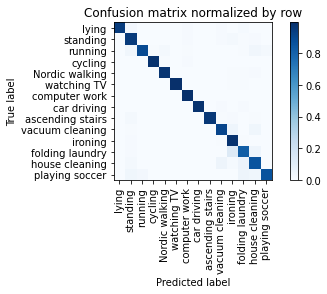

Overall accuracy: 0.944

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.984      0.992      0.988      0.148        614|	 folding laundry: 0.003,	house cleaning: 0.002,	
         ironing       0.882      0.978      0.928      0.111        460|	 standing: 0.011,	folding laundry: 0.007,	
  Nordic walking       0.987      0.972      0.979      0.094        392|	 house cleaning: 0.010,	ironing: 0.008,	
           lying       1.000      0.943      0.971      0.093        386|	 standing: 0.026,	folding laundry: 0.013,	
        standing       0.891      0.948      0.919      0.087        364|	 ironing: 0.022,	house cleaning: 0.008,	
  house cleaning       0.879      0.855      0.867      0.081        339|	 folding laundry: 0.056,	vacuum cleaning: 0.050,	
         cycling       0.994      0.979      0.986      0.079        330|	 computer work: 0.009,	Nordic walking: 0.006,	
 vacuum cleaning       0.912      0.909      0.910 

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

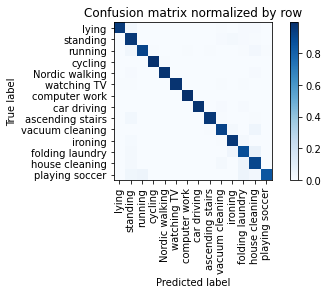

Overall accuracy: 0.951

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.995      0.993      0.994      0.146        609|	 house cleaning: 0.002,	folding laundry: 0.002,	
         ironing       0.947      0.959      0.953      0.111        462|	 folding laundry: 0.022,	standing: 0.013,	
  Nordic walking       0.995      0.974      0.984      0.094        391|	 house cleaning: 0.010,	standing: 0.010,	
           lying       0.997      0.948      0.972      0.093        386|	 standing: 0.028,	house cleaning: 0.008,	
        standing       0.868      0.955      0.910      0.086        359|	 ironing: 0.019,	vacuum cleaning: 0.011,	
  house cleaning       0.866      0.904      0.885      0.081        335|	 folding laundry: 0.048,	vacuum cleaning: 0.021,	
         cycling       0.994      0.982      0.988      0.080        331|	 Nordic walking: 0.006,	folding laundry: 0.003,	
 vacuum cleaning       0.940      0.920      0.9

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

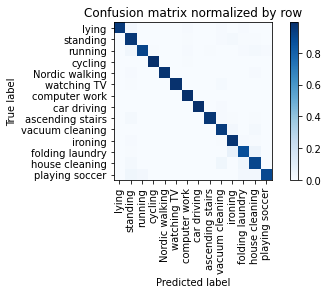

Overall accuracy: 0.955

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.984      0.990      0.987      0.147        613|	 folding laundry: 0.003,	standing: 0.003,	
         ironing       0.929      0.970      0.949      0.111        461|	 folding laundry: 0.011,	standing: 0.011,	
  Nordic walking       0.997      0.975      0.986      0.095        395|	 house cleaning: 0.010,	standing: 0.010,	
           lying       1.000      0.948      0.973      0.093        386|	 standing: 0.023,	computer work: 0.010,	
        standing       0.885      0.959      0.921      0.087        363|	 ironing: 0.017,	vacuum cleaning: 0.008,	
  house cleaning       0.901      0.901      0.901      0.081        335|	 folding laundry: 0.036,	vacuum cleaning: 0.036,	
         cycling       0.997      0.988      0.992      0.079        328|	 computer work: 0.006,	ironing: 0.003,	
 vacuum cleaning       0.920      0.940      0.930      0.076   

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

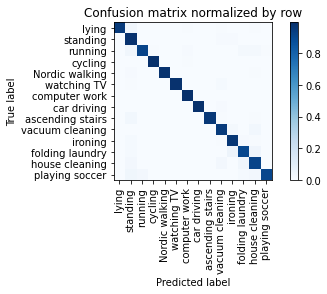

Overall accuracy: 0.961

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.990      0.993      0.992      0.146        609|	 standing: 0.003,	folding laundry: 0.002,	
         ironing       0.951      0.965      0.958      0.111        462|	 standing: 0.015,	folding laundry: 0.011,	
  Nordic walking       1.000      0.980      0.990      0.094        392|	 standing: 0.010,	house cleaning: 0.005,	
           lying       1.000      0.948      0.973      0.093        387|	 standing: 0.034,	house cleaning: 0.005,	
        standing       0.867      0.983      0.921      0.087        363|	 ironing: 0.008,	vacuum cleaning: 0.008,	
  house cleaning       0.913      0.913      0.913      0.081        335|	 folding laundry: 0.033,	vacuum cleaning: 0.024,	
         cycling       0.997      0.988      0.992      0.079        330|	 computer work: 0.006,	ironing: 0.003,	
 vacuum cleaning       0.938      0.950      0.944      0.077  

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

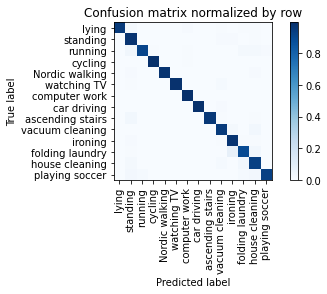

Overall accuracy: 0.962

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.987      0.993      0.990      0.147        612|	 standing: 0.003,	folding laundry: 0.002,	
         ironing       0.939      0.974      0.956      0.111        462|	 standing: 0.011,	folding laundry: 0.006,	
  Nordic walking       1.000      0.974      0.987      0.094        391|	 house cleaning: 0.010,	standing: 0.010,	
           lying       1.000      0.948      0.973      0.093        387|	 standing: 0.023,	computer work: 0.010,	
        standing       0.887      0.975      0.929      0.087        364|	 ironing: 0.008,	vacuum cleaning: 0.008,	
  house cleaning       0.906      0.928      0.917      0.080        332|	 folding laundry: 0.030,	standing: 0.021,	
         cycling       0.997      0.988      0.992      0.079        329|	 computer work: 0.006,	ironing: 0.003,	
 vacuum cleaning       0.947      0.947      0.947      0.078        32

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

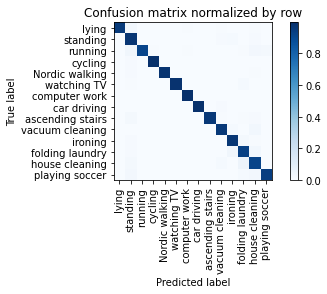

Overall accuracy: 0.963

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.995      0.995      0.995      0.147        612|	 standing: 0.003,	folding laundry: 0.002,	
         ironing       0.961      0.965      0.963      0.111        462|	 folding laundry: 0.017,	standing: 0.011,	
  Nordic walking       1.000      0.977      0.988      0.094        391|	 standing: 0.010,	house cleaning: 0.008,	
           lying       1.000      0.951      0.975      0.093        387|	 standing: 0.031,	house cleaning: 0.005,	
        standing       0.877      0.970      0.921      0.087        361|	 ironing: 0.014,	house cleaning: 0.008,	
  house cleaning       0.900      0.916      0.908      0.080        334|	 folding laundry: 0.048,	standing: 0.021,	
         cycling       0.997      0.988      0.992      0.080        332|	 standing: 0.009,	ironing: 0.003,	
 vacuum cleaning       0.956      0.959      0.958      0.077        320|	 h

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

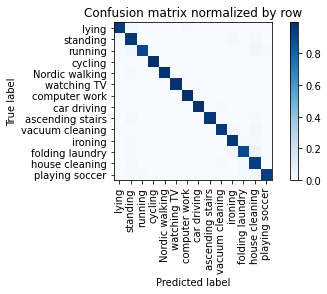

Overall accuracy: 0.963

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.990      0.995      0.993      0.146        608|	 standing: 0.003,	ironing: 0.002,	
         ironing       0.959      0.968      0.963      0.111        463|	 folding laundry: 0.011,	standing: 0.011,	
  Nordic walking       1.000      0.977      0.988      0.095        394|	 standing: 0.010,	house cleaning: 0.008,	
           lying       1.000      0.948      0.973      0.093        387|	 standing: 0.021,	computer work: 0.010,	
        standing       0.893      0.964      0.927      0.087        363|	 house cleaning: 0.017,	ironing: 0.017,	
  house cleaning       0.861      0.940      0.899      0.081        335|	 folding laundry: 0.030,	standing: 0.021,	
         cycling       1.000      0.991      0.995      0.080        332|	 folding laundry: 0.003,	ironing: 0.003,	
 vacuum cleaning       0.965      0.956      0.960      0.076        316|	 hou

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

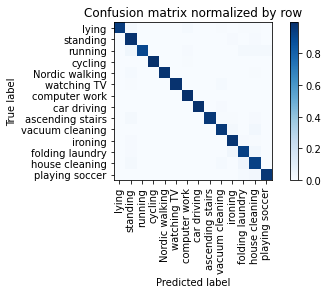

Overall accuracy: 0.965

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.985      0.995      0.990      0.147        611|	 standing: 0.003,	ironing: 0.002,	
         ironing       0.959      0.974      0.966      0.110        457|	 folding laundry: 0.009,	standing: 0.009,	
  Nordic walking       1.000      0.977      0.988      0.094        393|	 standing: 0.013,	house cleaning: 0.008,	
           lying       1.000      0.946      0.972      0.093        386|	 standing: 0.023,	computer work: 0.013,	
        standing       0.894      0.981      0.936      0.087        363|	 house cleaning: 0.011,	ironing: 0.008,	
  house cleaning       0.899      0.926      0.912      0.081        336|	 folding laundry: 0.042,	standing: 0.018,	
         cycling       1.000      0.988      0.994      0.079        329|	 computer work: 0.006,	ironing: 0.003,	
 vacuum cleaning       0.962      0.956      0.959      0.077        320|	 house

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

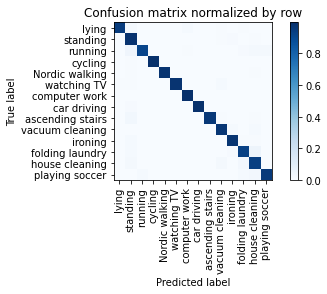

Overall accuracy: 0.967

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.990      0.995      0.993      0.147        611|	 standing: 0.003,	ironing: 0.002,	
         ironing       0.974      0.972      0.973      0.111        463|	 standing: 0.015,	house cleaning: 0.006,	
  Nordic walking       1.000      0.979      0.990      0.093        388|	 house cleaning: 0.008,	standing: 0.008,	
           lying       0.997      0.948      0.972      0.093        386|	 standing: 0.023,	computer work: 0.013,	
        standing       0.875      0.981      0.925      0.087        363|	 ironing: 0.008,	house cleaning: 0.006,	
  house cleaning       0.912      0.934      0.923      0.080        334|	 folding laundry: 0.027,	standing: 0.021,	
         cycling       1.000      0.991      0.995      0.080        333|	 standing: 0.006,	ironing: 0.003,	
 vacuum cleaning       0.954      0.969      0.961      0.077        322|	 house clean

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

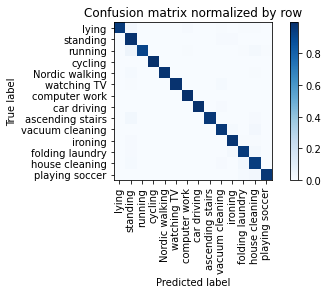

Overall accuracy: 0.970

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.990      0.995      0.993      0.146        609|	 standing: 0.003,	ironing: 0.002,	
         ironing       0.968      0.974      0.971      0.111        461|	 standing: 0.011,	house cleaning: 0.007,	
  Nordic walking       1.000      0.977      0.988      0.094        393|	 standing: 0.013,	house cleaning: 0.005,	
           lying       1.000      0.951      0.975      0.092        384|	 standing: 0.023,	computer work: 0.010,	
        standing       0.885      0.983      0.932      0.087        361|	 ironing: 0.008,	vacuum cleaning: 0.008,	
  house cleaning       0.922      0.941      0.931      0.081        338|	 folding laundry: 0.030,	standing: 0.015,	
         cycling       1.000      0.991      0.995      0.080        332|	 ironing: 0.003,	computer work: 0.003,	
 vacuum cleaning       0.959      0.962      0.961      0.077        319|	 house

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

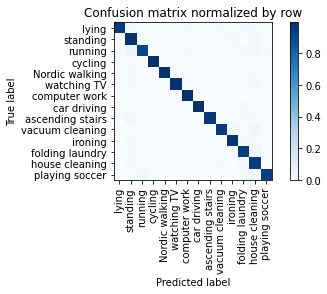

Overall accuracy: 0.969

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.989      0.993      0.991      0.147        613|	 standing: 0.003,	folding laundry: 0.002,	
         ironing       0.974      0.974      0.974      0.110        458|	 folding laundry: 0.009,	standing: 0.009,	
  Nordic walking       1.000      0.980      0.990      0.094        393|	 standing: 0.010,	house cleaning: 0.008,	
           lying       1.000      0.951      0.975      0.093        387|	 standing: 0.021,	computer work: 0.013,	
        standing       0.898      0.981      0.938      0.087        361|	 house cleaning: 0.011,	ironing: 0.008,	
  house cleaning       0.885      0.959      0.920      0.081        338|	 folding laundry: 0.018,	standing: 0.015,	
         cycling       1.000      0.994      0.997      0.079        330|	 ironing: 0.003,	computer work: 0.003,	
 vacuum cleaning       0.984      0.947      0.965      0.077        320

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

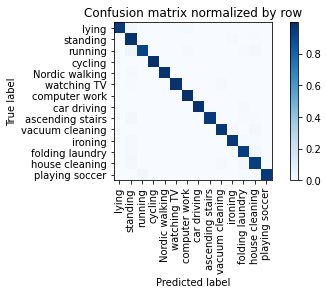

Overall accuracy: 0.971

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.987      0.997      0.992      0.148        615|	 ironing: 0.002,	standing: 0.002,	
         ironing       0.974      0.967      0.971      0.111        461|	 folding laundry: 0.015,	standing: 0.011,	
  Nordic walking       1.000      0.982      0.991      0.094        392|	 standing: 0.010,	house cleaning: 0.003,	
           lying       1.000      0.955      0.977      0.092        382|	 standing: 0.024,	computer work: 0.013,	
        standing       0.891      0.986      0.936      0.087        363|	 ironing: 0.008,	house cleaning: 0.006,	
  house cleaning       0.930      0.941      0.935      0.081        337|	 folding laundry: 0.030,	standing: 0.018,	
         cycling       1.000      0.994      0.997      0.079        330|	 ironing: 0.003,	computer work: 0.003,	
 vacuum cleaning       0.978      0.966      0.972      0.077        320|	 house

unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

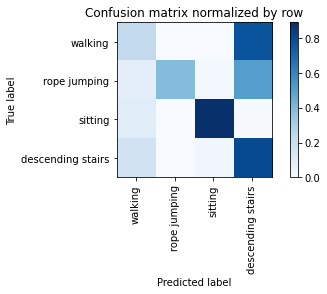

Overall accuracy: 0.554

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.581      0.230      0.329      0.421       2319|	 descending stairs: 0.765,	sitting: 0.006,	
          sitting       0.968      0.889      0.927      0.324       1785|	 walking: 0.103,	descending stairs: 0.008,	
descending stairs       0.271      0.796      0.404      0.171        942|	 walking: 0.173,	sitting: 0.031,	
     rope jumping       1.000      0.386      0.557      0.083        458|	 descending stairs: 0.507,	walking: 0.085,	

----------------------------------------------------------------------------------------------------
      avg / total       0.688      0.554      0.555        1.0       5504|	      

{'accuracy': 0.5535973837209303, 'precision': 0.7049103704827572, 'recall': 0.5753893261915958, 'f1': 0.5544695982328883}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'com

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

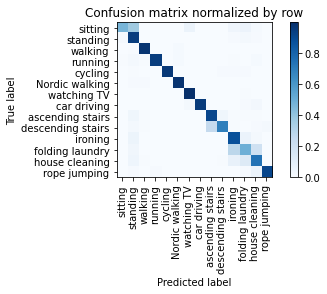

Overall accuracy: 0.842

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.801      0.873      0.835      0.133        511|	 folding laundry: 0.059,	standing: 0.053,	
          walking       0.979      0.975      0.977      0.113        435|	 Nordic walking: 0.014,	standing: 0.007,	
   house cleaning       0.788      0.738      0.762      0.096        367|	 folding laundry: 0.125,	ironing: 0.074,	
   Nordic walking       0.978      0.975      0.976      0.094        361|	 standing: 0.011,	walking: 0.008,	
         standing       0.633      0.943      0.758      0.092        353|	 folding laundry: 0.020,	sitting: 0.017,	
          sitting       0.943      0.464      0.622      0.084        323|	 standing: 0.365,	watching TV: 0.062,	
          cycling       0.996      0.959      0.978      0.077        296|	 folding laundry: 0.010,	ironing: 0.010,	
  folding laundry       0.495      0.491      0.493      0.056        21

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

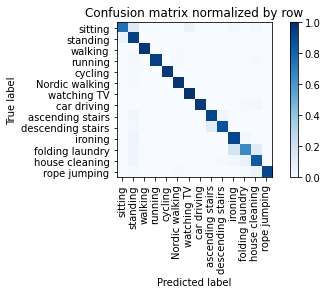

Overall accuracy: 0.902

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.884      0.912      0.897      0.133        509|	 standing: 0.049,	folding laundry: 0.028,	
          walking       0.988      0.982      0.985      0.114        437|	 standing: 0.007,	descending stairs: 0.005,	
   house cleaning       0.866      0.840      0.853      0.096        369|	 folding laundry: 0.068,	standing: 0.046,	
   Nordic walking       0.986      0.975      0.981      0.095        364|	 standing: 0.011,	house cleaning: 0.005,	
         standing       0.725      0.934      0.817      0.091        348|	 sitting: 0.063,	folding laundry: 0.003,	
          sitting       0.891      0.753      0.816      0.084        324|	 standing: 0.133,	watching TV: 0.065,	
          cycling       0.997      0.963      0.979      0.077        297|	 standing: 0.013,	house cleaning: 0.007,	
 ascending stairs       0.900      0.921      0.911      0.05

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

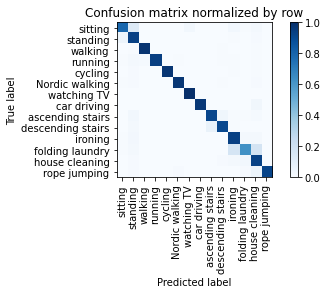

Overall accuracy: 0.917

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.889      0.937      0.912      0.133        511|	 standing: 0.023,	folding laundry: 0.020,	
          walking       0.993      0.982      0.987      0.113        435|	 house cleaning: 0.005,	descending stairs: 0.005,	
   house cleaning       0.815      0.926      0.867      0.096        367|	 folding laundry: 0.030,	ironing: 0.019,	
   Nordic walking       0.992      0.970      0.981      0.095        364|	 house cleaning: 0.008,	standing: 0.008,	
         standing       0.794      0.932      0.858      0.092        352|	 sitting: 0.051,	house cleaning: 0.011,	
          sitting       0.911      0.788      0.845      0.085        326|	 standing: 0.129,	ironing: 0.028,	
          cycling       1.000      0.973      0.986      0.077        297|	 standing: 0.010,	house cleaning: 0.007,	
 ascending stairs       0.933      0.912      0.922      0.05

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

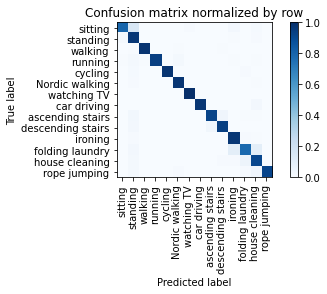

Overall accuracy: 0.935

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.932      0.969      0.950      0.133        512|	 folding laundry: 0.012,	standing: 0.012,	
          walking       0.993      0.982      0.987      0.115        440|	 standing: 0.007,	descending stairs: 0.005,	
   house cleaning       0.886      0.908      0.897      0.096        368|	 folding laundry: 0.049,	standing: 0.022,	
   Nordic walking       0.983      0.975      0.979      0.095        364|	 standing: 0.011,	house cleaning: 0.005,	
         standing       0.779      0.969      0.864      0.091        350|	 sitting: 0.017,	house cleaning: 0.009,	
          sitting       0.962      0.790      0.868      0.084        324|	 standing: 0.154,	ironing: 0.025,	
          cycling       1.000      0.977      0.988      0.078        301|	 standing: 0.013,	folding laundry: 0.010,	
 ascending stairs       0.966      0.921      0.943      0.056   

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

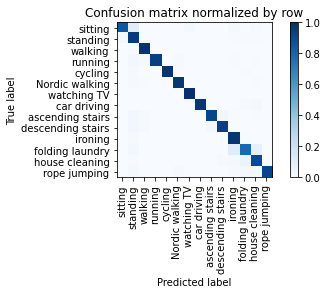

Overall accuracy: 0.940

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.919      0.982      0.950      0.133        511|	 standing: 0.010,	folding laundry: 0.004,	
          walking       0.977      0.986      0.982      0.114        436|	 standing: 0.007,	ironing: 0.002,	
   house cleaning       0.914      0.899      0.906      0.095        365|	 folding laundry: 0.060,	ironing: 0.019,	
   Nordic walking       0.989      0.973      0.981      0.095        364|	 standing: 0.011,	house cleaning: 0.005,	
         standing       0.819      0.960      0.884      0.092        353|	 sitting: 0.023,	house cleaning: 0.006,	
          sitting       0.965      0.845      0.901      0.084        323|	 standing: 0.102,	watching TV: 0.022,	
          cycling       1.000      0.977      0.988      0.078        300|	 standing: 0.010,	folding laundry: 0.007,	
  folding laundry       0.836      0.781      0.808      0.056        21

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

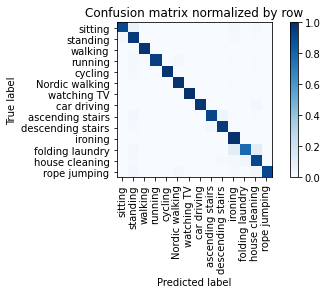

Overall accuracy: 0.947

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.914      0.988      0.949      0.134        513|	 standing: 0.004,	sitting: 0.004,	
          walking       0.988      0.984      0.986      0.113        433|	 standing: 0.007,	descending stairs: 0.005,	
   Nordic walking       0.983      0.978      0.981      0.095        364|	 ironing: 0.005,	walking: 0.005,	
   house cleaning       0.894      0.914      0.904      0.094        360|	 folding laundry: 0.036,	ironing: 0.022,	
         standing       0.860      0.960      0.907      0.091        351|	 sitting: 0.026,	ironing: 0.009,	
          sitting       0.955      0.899      0.926      0.085        328|	 standing: 0.064,	ironing: 0.021,	
          cycling       1.000      0.977      0.988      0.078        300|	 standing: 0.010,	house cleaning: 0.007,	
 ascending stairs       0.975      0.921      0.948      0.056        216|	 descending sta

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

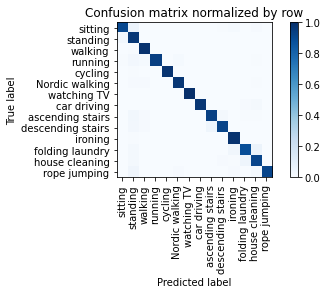

Overall accuracy: 0.954

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.965      0.988      0.977      0.132        506|	 standing: 0.006,	house cleaning: 0.002,	
          walking       0.975      0.989      0.982      0.115        440|	 standing: 0.005,	ironing: 0.002,	
   house cleaning       0.926      0.916      0.921      0.096        367|	 folding laundry: 0.044,	standing: 0.022,	
   Nordic walking       0.989      0.972      0.981      0.095        363|	 walking: 0.008,	standing: 0.008,	
         standing       0.845      0.966      0.902      0.091        351|	 sitting: 0.028,	house cleaning: 0.003,	
          sitting       0.954      0.904      0.929      0.084        324|	 standing: 0.062,	ironing: 0.015,	
          cycling       1.000      0.983      0.992      0.078        299|	 standing: 0.007,	house cleaning: 0.003,	
 ascending stairs       0.957      0.935      0.946      0.056        216|	 standing

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

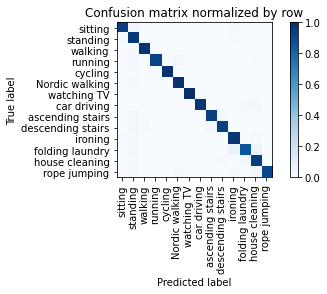

Overall accuracy: 0.957

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.954      0.975      0.964      0.133        512|	 house cleaning: 0.010,	standing: 0.008,	
          walking       0.984      0.984      0.984      0.115        440|	 descending stairs: 0.005,	standing: 0.005,	
   house cleaning       0.922      0.943      0.932      0.095        366|	 folding laundry: 0.030,	standing: 0.014,	
   Nordic walking       0.978      0.978      0.978      0.095        366|	 standing: 0.011,	walking: 0.005,	
         standing       0.871      0.968      0.917      0.091        349|	 sitting: 0.023,	ironing: 0.006,	
          sitting       0.959      0.941      0.950      0.084        324|	 standing: 0.034,	ironing: 0.015,	
          cycling       0.997      0.987      0.992      0.078        298|	 standing: 0.007,	ironing: 0.003,	
 ascending stairs       0.971      0.939      0.955      0.056        214|	 standing: 0.

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

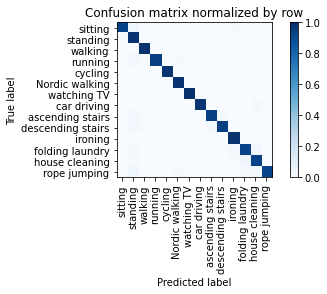

Overall accuracy: 0.963

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.964      0.986      0.975      0.133        510|	 sitting: 0.006,	standing: 0.004,	
          walking       0.984      0.986      0.985      0.114        438|	 standing: 0.007,	ironing: 0.002,	
   house cleaning       0.952      0.926      0.939      0.095        366|	 folding laundry: 0.044,	standing: 0.014,	
   Nordic walking       0.989      0.984      0.986      0.095        364|	 ironing: 0.005,	standing: 0.005,	
         standing       0.871      0.983      0.924      0.091        351|	 sitting: 0.009,	ironing: 0.006,	
          sitting       0.974      0.926      0.949      0.084        324|	 standing: 0.043,	ironing: 0.015,	
          cycling       0.997      0.983      0.990      0.079        302|	 standing: 0.007,	folding laundry: 0.003,	
 ascending stairs       0.976      0.939      0.957      0.056        214|	 standing: 0.028,	desc

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

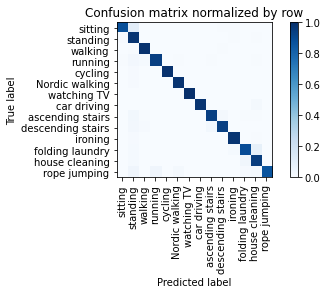

Overall accuracy: 0.957

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.986      0.977      0.981      0.134        516|	 standing: 0.012,	house cleaning: 0.006,	
          walking       0.986      0.989      0.987      0.114        438|	 descending stairs: 0.005,	standing: 0.005,	
   house cleaning       0.918      0.948      0.933      0.096        367|	 folding laundry: 0.033,	standing: 0.014,	
   Nordic walking       0.992      0.983      0.987      0.094        360|	 standing: 0.008,	house cleaning: 0.003,	
         standing       0.823      0.977      0.894      0.092        352|	 sitting: 0.009,	house cleaning: 0.006,	
          sitting       0.979      0.880      0.927      0.084        324|	 standing: 0.102,	ironing: 0.006,	
          cycling       1.000      0.990      0.995      0.078        298|	 standing: 0.010,	rope jumping: 0.000,	
  folding laundry       0.905      0.888      0.897      0.056       

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

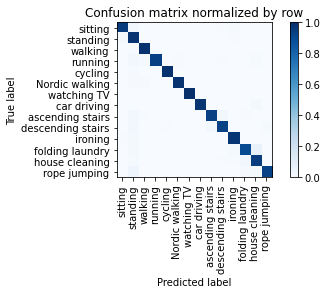

Overall accuracy: 0.963

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.976      0.976      0.976      0.132        508|	 standing: 0.018,	sitting: 0.004,	
          walking       0.984      0.989      0.986      0.114        437|	 standing: 0.005,	ironing: 0.002,	
   house cleaning       0.938      0.943      0.940      0.096        367|	 folding laundry: 0.030,	standing: 0.014,	
   Nordic walking       0.994      0.978      0.986      0.095        366|	 standing: 0.011,	walking: 0.008,	
         standing       0.863      0.977      0.917      0.092        354|	 sitting: 0.017,	ironing: 0.006,	
          sitting       0.974      0.950      0.962      0.083        320|	 standing: 0.028,	ironing: 0.013,	
          cycling       0.997      0.990      0.993      0.077        295|	 standing: 0.010,	rope jumping: 0.000,	
 ascending stairs       0.976      0.935      0.955      0.056        216|	 descending stairs: 0.028

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

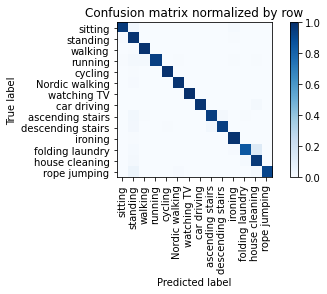

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.975      0.988      0.981      0.133        510|	 standing: 0.006,	house cleaning: 0.002,	
          walking       0.986      0.989      0.987      0.114        439|	 standing: 0.005,	ironing: 0.002,	
   Nordic walking       0.992      0.984      0.988      0.095        364|	 standing: 0.008,	house cleaning: 0.003,	
   house cleaning       0.906      0.961      0.933      0.094        362|	 standing: 0.019,	folding laundry: 0.014,	
         standing       0.878      0.983      0.927      0.091        351|	 sitting: 0.011,	ironing: 0.006,	
          sitting       0.981      0.954      0.967      0.085        325|	 standing: 0.028,	ironing: 0.012,	
          cycling       0.997      0.990      0.993      0.078        299|	 standing: 0.007,	ironing: 0.003,	
  folding laundry       0.958      0.847      0.899      0.056        215|	 house cleaning:

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

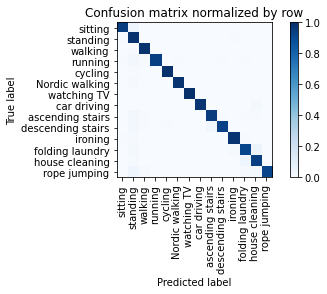

Overall accuracy: 0.965

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.984      0.980      0.982      0.133        511|	 standing: 0.008,	folding laundry: 0.006,	
          walking       0.988      0.986      0.987      0.113        433|	 standing: 0.007,	ironing: 0.002,	
   house cleaning       0.943      0.940      0.941      0.096        367|	 folding laundry: 0.041,	standing: 0.014,	
   Nordic walking       0.994      0.984      0.989      0.095        366|	 standing: 0.011,	house cleaning: 0.003,	
         standing       0.859      0.986      0.918      0.091        351|	 ironing: 0.006,	sitting: 0.006,	
          sitting       0.984      0.945      0.964      0.085        327|	 standing: 0.046,	house cleaning: 0.003,	
          cycling       0.997      0.990      0.993      0.078        298|	 standing: 0.007,	ironing: 0.003,	
  folding laundry       0.898      0.910      0.904      0.055        212|	 house c

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

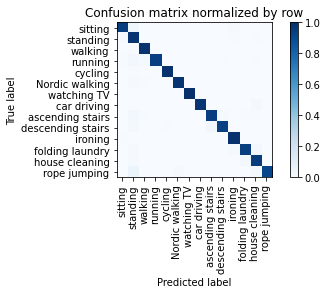

Overall accuracy: 0.969

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.977      0.988      0.983      0.134        515|	 sitting: 0.006,	standing: 0.004,	
          walking       0.986      0.986      0.986      0.114        436|	 standing: 0.007,	ironing: 0.002,	
   Nordic walking       0.994      0.984      0.989      0.095        364|	 standing: 0.008,	walking: 0.005,	
   house cleaning       0.958      0.950      0.954      0.095        363|	 folding laundry: 0.030,	standing: 0.014,	
         standing       0.876      0.977      0.924      0.092        355|	 sitting: 0.011,	house cleaning: 0.006,	
          sitting       0.971      0.947      0.959      0.084        323|	 standing: 0.037,	ironing: 0.009,	
          cycling       0.997      0.990      0.993      0.077        297|	 standing: 0.007,	ironing: 0.003,	
  folding laundry       0.940      0.949      0.944      0.056        214|	 house cleaning: 0.028,

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

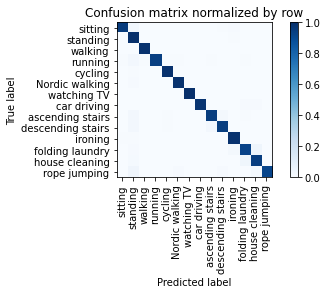

Overall accuracy: 0.970

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.977      0.990      0.983      0.133        509|	 standing: 0.004,	sitting: 0.004,	
          walking       0.993      0.991      0.992      0.114        438|	 ironing: 0.002,	descending stairs: 0.002,	
   house cleaning       0.961      0.943      0.952      0.096        368|	 folding laundry: 0.035,	standing: 0.014,	
   Nordic walking       0.992      0.986      0.989      0.095        365|	 standing: 0.011,	walking: 0.003,	
         standing       0.889      0.994      0.939      0.092        353|	 ironing: 0.006,	rope jumping: 0.000,	
          sitting       0.990      0.950      0.970      0.084        323|	 standing: 0.031,	ironing: 0.009,	
          cycling       0.990      0.990      0.990      0.078        301|	 standing: 0.007,	ironing: 0.003,	
  folding laundry       0.921      0.925      0.923      0.056        214|	 house cleaning:

unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

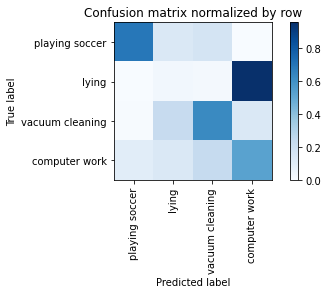

Overall accuracy: 0.429

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.445      0.528      0.483      0.432       3070|	 vacuum cleaning: 0.236,	lying: 0.134,	
          lying       0.055      0.027      0.036      0.264       1876|	 computer work: 0.953,	vacuum cleaning: 0.018,	
vacuum cleaning       0.560      0.625      0.590      0.240       1702|	 lying: 0.233,	computer work: 0.137,	
 playing soccer       0.492      0.691      0.575      0.064        456|	 vacuum cleaning: 0.171,	lying: 0.138,	

----------------------------------------------------------------------------------------------------
    avg / total       0.373      0.429      0.397        1.0       7104|	      

{'accuracy': 0.42947635135135137, 'precision': 0.38812694359907646, 'recall': 0.46771826972898467, 'f1': 0.42122628958899355}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  [0

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

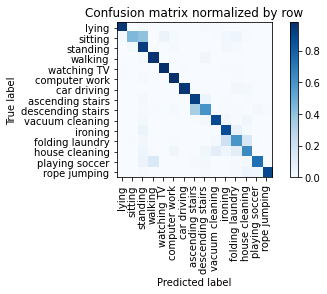

Overall accuracy: 0.836

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.954      0.975      0.965      0.136        602|	 standing: 0.008,	folding laundry: 0.007,	
          walking       0.968      0.956      0.962      0.108        477|	 descending stairs: 0.034,	standing: 0.008,	
          ironing       0.815      0.867      0.840      0.102        452|	 folding laundry: 0.066,	standing: 0.051,	
         standing       0.613      0.931      0.739      0.085        375|	 ironing: 0.024,	sitting: 0.019,	
   house cleaning       0.785      0.634      0.702      0.084        369|	 folding laundry: 0.100,	vacuum cleaning: 0.098,	
            lying       0.977      0.950      0.964      0.082        363|	 standing: 0.022,	descending stairs: 0.011,	
          sitting       0.940      0.441      0.600      0.080        354|	 standing: 0.398,	watching TV: 0.056,	
  vacuum cleaning       0.868      0.880      0.874      0

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

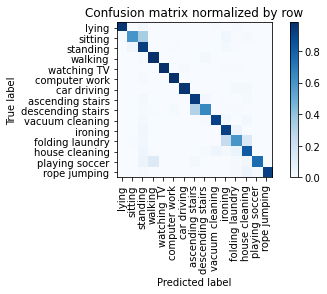

Overall accuracy: 0.879

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.980      0.987      0.137        605|	 standing: 0.010,	folding laundry: 0.003,	
          walking       0.971      0.973      0.972      0.108        476|	 descending stairs: 0.017,	standing: 0.011,	
          ironing       0.827      0.918      0.870      0.103        453|	 folding laundry: 0.049,	standing: 0.031,	
         standing       0.645      0.928      0.761      0.085        377|	 sitting: 0.040,	ironing: 0.019,	
   house cleaning       0.848      0.821      0.834      0.083        368|	 folding laundry: 0.060,	vacuum cleaning: 0.041,	
            lying       0.989      0.956      0.972      0.082        360|	 standing: 0.028,	folding laundry: 0.008,	
          sitting       0.917      0.596      0.723      0.080        354|	 standing: 0.336,	ironing: 0.037,	
  vacuum cleaning       0.939      0.915      0.927      0.080  

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

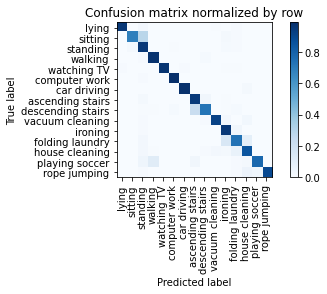

Overall accuracy: 0.904

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.987      0.990      0.137        606|	 standing: 0.008,	house cleaning: 0.003,	
          walking       0.973      0.975      0.974      0.107        474|	 descending stairs: 0.015,	standing: 0.011,	
          ironing       0.872      0.954      0.911      0.102        452|	 folding laundry: 0.033,	standing: 0.011,	
         standing       0.703      0.955      0.809      0.085        376|	 sitting: 0.019,	ironing: 0.013,	
   house cleaning       0.883      0.844      0.863      0.083        366|	 folding laundry: 0.068,	vacuum cleaning: 0.025,	
            lying       0.994      0.956      0.975      0.082        362|	 standing: 0.025,	folding laundry: 0.011,	
          sitting       0.964      0.685      0.801      0.080        355|	 standing: 0.282,	ironing: 0.020,	
  vacuum cleaning       0.961      0.915      0.937      0.079   

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

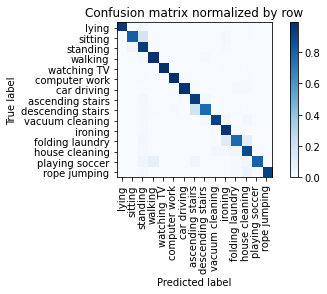

Overall accuracy: 0.925

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.990      0.992      0.137        605|	 house cleaning: 0.005,	standing: 0.005,	
          walking       0.979      0.979      0.979      0.107        474|	 descending stairs: 0.011,	standing: 0.011,	
          ironing       0.890      0.969      0.928      0.103        453|	 standing: 0.015,	folding laundry: 0.013,	
         standing       0.765      0.947      0.846      0.085        374|	 sitting: 0.035,	ironing: 0.011,	
   house cleaning       0.879      0.886      0.882      0.083        368|	 folding laundry: 0.035,	vacuum cleaning: 0.027,	
            lying       1.000      0.959      0.979      0.082        363|	 standing: 0.025,	house cleaning: 0.006,	
          sitting       0.947      0.805      0.870      0.080        354|	 standing: 0.167,	ironing: 0.020,	
  vacuum cleaning       0.955      0.917      0.936      0.079    

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

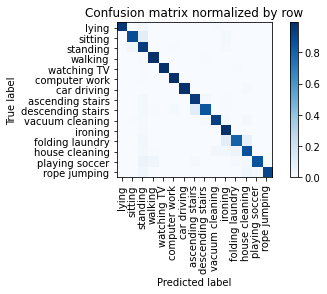

Overall accuracy: 0.938

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.990      0.992      0.137        604|	 standing: 0.007,	house cleaning: 0.003,	
          walking       0.985      0.983      0.984      0.108        476|	 standing: 0.011,	descending stairs: 0.006,	
          ironing       0.903      0.985      0.942      0.103        453|	 standing: 0.011,	folding laundry: 0.002,	
         standing       0.792      0.944      0.862      0.085        376|	 sitting: 0.035,	ironing: 0.011,	
   house cleaning       0.907      0.870      0.888      0.083        368|	 folding laundry: 0.049,	ironing: 0.024,	
            lying       1.000      0.959      0.979      0.082        362|	 standing: 0.028,	vacuum cleaning: 0.006,	
          sitting       0.951      0.879      0.914      0.081        356|	 standing: 0.096,	ironing: 0.020,	
  vacuum cleaning       0.959      0.931      0.945      0.079        350

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

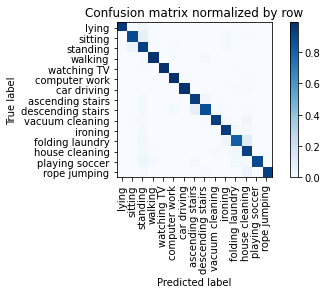

Overall accuracy: 0.940

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.990      0.992      0.137        604|	 house cleaning: 0.005,	sitting: 0.003,	
          walking       0.994      0.979      0.986      0.108        475|	 descending stairs: 0.011,	standing: 0.011,	
          ironing       0.947      0.947      0.947      0.103        454|	 folding laundry: 0.022,	standing: 0.018,	
         standing       0.803      0.931      0.862      0.085        376|	 sitting: 0.051,	ironing: 0.013,	
   house cleaning       0.857      0.927      0.890      0.083        368|	 folding laundry: 0.030,	standing: 0.016,	
            lying       1.000      0.958      0.979      0.082        361|	 standing: 0.033,	house cleaning: 0.003,	
          sitting       0.930      0.893      0.911      0.081        356|	 standing: 0.084,	ironing: 0.014,	
  vacuum cleaning       0.971      0.935      0.952      0.080        352|

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

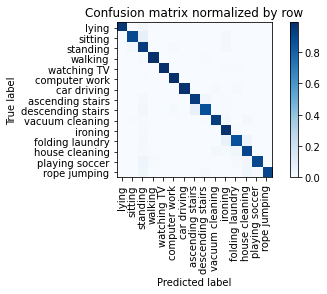

Overall accuracy: 0.947

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.990      0.990      0.137        605|	 standing: 0.007,	house cleaning: 0.003,	
          walking       0.994      0.983      0.988      0.108        477|	 standing: 0.010,	descending stairs: 0.006,	
          ironing       0.914      0.982      0.947      0.102        452|	 standing: 0.011,	folding laundry: 0.004,	
         standing       0.812      0.944      0.873      0.085        376|	 sitting: 0.027,	ironing: 0.016,	
   house cleaning       0.922      0.910      0.916      0.083        365|	 folding laundry: 0.036,	vacuum cleaning: 0.022,	
            lying       1.000      0.961      0.980      0.082        360|	 standing: 0.033,	house cleaning: 0.003,	
          sitting       0.961      0.896      0.927      0.081        356|	 standing: 0.079,	ironing: 0.020,	
  vacuum cleaning       0.962      0.938      0.950      0.080    

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

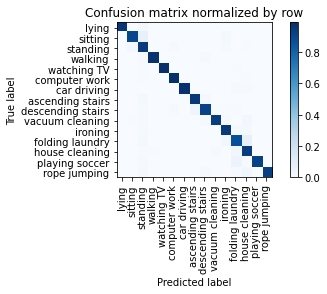

Overall accuracy: 0.950

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.137        604|	 house cleaning: 0.005,	standing: 0.005,	
          walking       0.996      0.975      0.985      0.108        477|	 descending stairs: 0.015,	standing: 0.010,	
          ironing       0.951      0.953      0.952      0.102        451|	 house cleaning: 0.016,	folding laundry: 0.016,	
         standing       0.831      0.947      0.885      0.085        375|	 sitting: 0.024,	ironing: 0.013,	
   house cleaning       0.885      0.940      0.911      0.083        367|	 folding laundry: 0.033,	vacuum cleaning: 0.014,	
            lying       1.000      0.961      0.980      0.082        362|	 standing: 0.030,	house cleaning: 0.003,	
          sitting       0.964      0.904      0.933      0.081        356|	 standing: 0.073,	ironing: 0.017,	
  vacuum cleaning       0.973      0.937      0.955      0.0

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

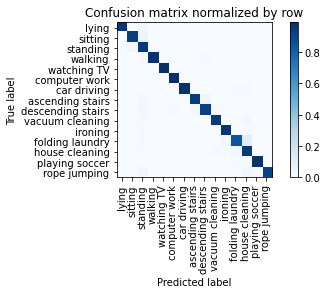

Overall accuracy: 0.957

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.990      0.992      0.136        600|	 standing: 0.007,	house cleaning: 0.003,	
          walking       0.996      0.981      0.988      0.108        476|	 standing: 0.011,	descending stairs: 0.008,	
          ironing       0.976      0.974      0.975      0.103        454|	 standing: 0.013,	folding laundry: 0.007,	
         standing       0.840      0.955      0.894      0.085        374|	 sitting: 0.032,	ironing: 0.005,	
   house cleaning       0.886      0.949      0.916      0.084        369|	 folding laundry: 0.024,	vacuum cleaning: 0.014,	
            lying       1.000      0.961      0.980      0.082        362|	 standing: 0.030,	house cleaning: 0.003,	
          sitting       0.957      0.935      0.946      0.080        355|	 standing: 0.054,	ironing: 0.006,	
  vacuum cleaning       0.971      0.952      0.961      0.080    

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

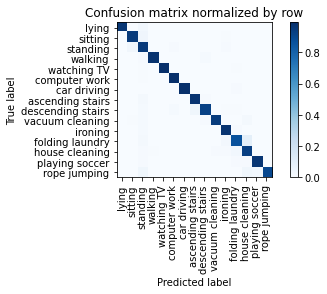

Overall accuracy: 0.958

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.992      0.992      0.136        602|	 standing: 0.005,	house cleaning: 0.003,	
          walking       0.996      0.979      0.987      0.108        476|	 descending stairs: 0.013,	standing: 0.008,	
          ironing       0.965      0.976      0.970      0.102        451|	 standing: 0.013,	folding laundry: 0.009,	
         standing       0.850      0.950      0.897      0.085        377|	 sitting: 0.032,	ironing: 0.008,	
   house cleaning       0.907      0.932      0.919      0.083        367|	 folding laundry: 0.030,	ironing: 0.011,	
            lying       1.000      0.964      0.982      0.082        363|	 standing: 0.030,	house cleaning: 0.003,	
          sitting       0.957      0.947      0.952      0.081        356|	 standing: 0.042,	ironing: 0.006,	
  vacuum cleaning       0.979      0.943      0.961      0.079        351|

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

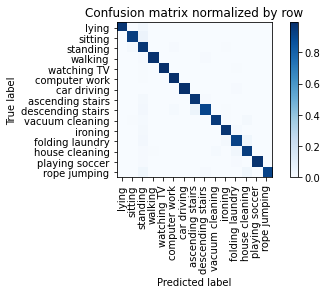

Overall accuracy: 0.961

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.137        604|	 standing: 0.007,	house cleaning: 0.003,	
          walking       0.996      0.981      0.988      0.108        478|	 standing: 0.010,	descending stairs: 0.008,	
          ironing       0.978      0.969      0.973      0.102        452|	 standing: 0.015,	folding laundry: 0.013,	
         standing       0.828      0.963      0.891      0.085        376|	 sitting: 0.021,	computer work: 0.008,	
   house cleaning       0.935      0.938      0.936      0.084        369|	 folding laundry: 0.033,	vacuum cleaning: 0.014,	
            lying       1.000      0.964      0.982      0.082        360|	 standing: 0.031,	house cleaning: 0.003,	
          sitting       0.968      0.935      0.951      0.080        354|	 standing: 0.056,	house cleaning: 0.003,	
  vacuum cleaning       0.979      0.952      0.965  

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

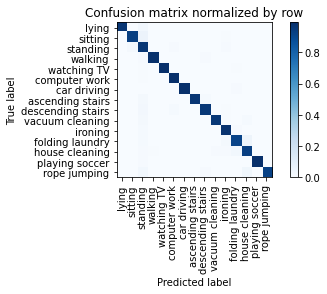

Overall accuracy: 0.964

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.137        604|	 standing: 0.007,	house cleaning: 0.003,	
          walking       0.996      0.983      0.989      0.108        478|	 descending stairs: 0.008,	standing: 0.008,	
          ironing       0.965      0.976      0.970      0.103        453|	 standing: 0.013,	folding laundry: 0.009,	
         standing       0.834      0.963      0.894      0.085        376|	 sitting: 0.021,	ironing: 0.008,	
   house cleaning       0.937      0.930      0.933      0.084        369|	 folding laundry: 0.030,	ironing: 0.011,	
            lying       1.000      0.964      0.982      0.082        362|	 standing: 0.030,	house cleaning: 0.003,	
          sitting       0.971      0.932      0.951      0.080        354|	 standing: 0.056,	ironing: 0.006,	
  vacuum cleaning       0.979      0.957      0.968      0.079        349|

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

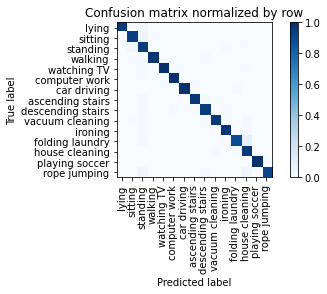

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.995      0.990      0.993      0.137        603|	 standing: 0.005,	house cleaning: 0.003,	
          walking       0.998      0.983      0.991      0.108        478|	 descending stairs: 0.010,	standing: 0.006,	
          ironing       0.984      0.976      0.980      0.102        452|	 standing: 0.011,	house cleaning: 0.009,	
         standing       0.858      0.949      0.902      0.085        376|	 sitting: 0.035,	ironing: 0.008,	
   house cleaning       0.901      0.967      0.933      0.083        367|	 folding laundry: 0.011,	vacuum cleaning: 0.011,	
            lying       1.000      0.964      0.982      0.082        360|	 standing: 0.028,	house cleaning: 0.003,	
          sitting       0.954      0.941      0.948      0.080        355|	 standing: 0.051,	house cleaning: 0.003,	
  vacuum cleaning       0.980      0.960      0.970      0.0

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

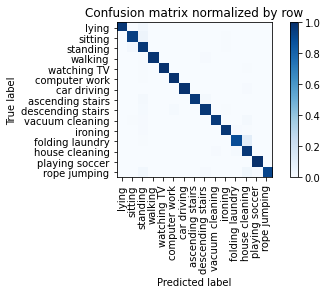

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.995      0.992      0.993      0.137        605|	 standing: 0.005,	house cleaning: 0.003,	
          walking       0.998      0.983      0.990      0.108        477|	 descending stairs: 0.010,	standing: 0.006,	
          ironing       0.986      0.969      0.978      0.102        450|	 folding laundry: 0.011,	standing: 0.011,	
         standing       0.870      0.965      0.915      0.085        375|	 sitting: 0.024,	ironing: 0.005,	
   house cleaning       0.892      0.967      0.928      0.083        368|	 folding laundry: 0.014,	vacuum cleaning: 0.011,	
            lying       1.000      0.967      0.983      0.082        361|	 standing: 0.028,	house cleaning: 0.003,	
          sitting       0.965      0.938      0.951      0.080        355|	 standing: 0.051,	ironing: 0.006,	
  vacuum cleaning       0.980      0.957      0.968      0.079    

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

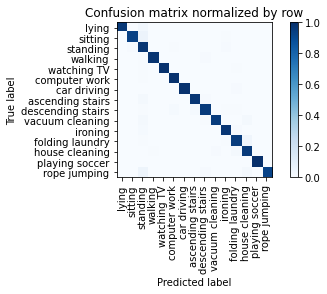

Overall accuracy: 0.969

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.992      0.993      0.137        604|	 standing: 0.005,	house cleaning: 0.003,	
          walking       0.996      0.983      0.989      0.108        476|	 descending stairs: 0.011,	standing: 0.004,	
          ironing       0.984      0.976      0.980      0.103        453|	 standing: 0.013,	folding laundry: 0.009,	
         standing       0.857      0.976      0.913      0.085        376|	 ironing: 0.008,	sitting: 0.008,	
   house cleaning       0.941      0.959      0.950      0.083        366|	 folding laundry: 0.016,	vacuum cleaning: 0.011,	
            lying       1.000      0.964      0.982      0.082        362|	 standing: 0.030,	house cleaning: 0.003,	
          sitting       0.985      0.932      0.958      0.080        355|	 standing: 0.056,	ironing: 0.006,	
  vacuum cleaning       0.980      0.952      0.965      0.080    

unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

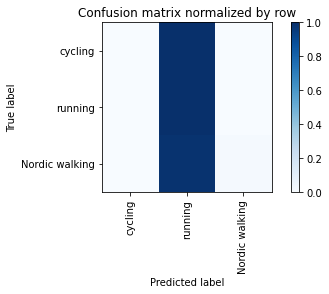

Overall accuracy: 0.222

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       1.000      0.014      0.027      0.418       1821|	 running: 0.986,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.365       1588|	 running: 1.000,	Nordic walking: 0.000,	
       running       0.218      1.000      0.358      0.217        943|	 Nordic walking: 0.000,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.466      0.222      0.089        1.0       4352|	      

{'accuracy': 0.22242647058823528, 'precision': 0.40597796779909096, 'recall': 0.337909573494417, 'f1': 0.12832011775807378}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

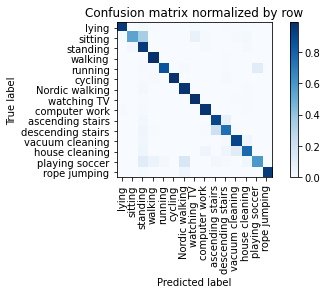

Overall accuracy: 0.885

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.958      0.966      0.962      0.131        587|	 standing: 0.014,	lying: 0.009,	
          walking       0.967      0.987      0.977      0.106        475|	 descending stairs: 0.006,	standing: 0.006,	
            lying       0.974      0.946      0.960      0.087        389|	 standing: 0.018,	watching TV: 0.013,	
         standing       0.630      0.949      0.757      0.083        373|	 sitting: 0.027,	computer work: 0.013,	
          sitting       0.943      0.538      0.685      0.082        368|	 standing: 0.340,	watching TV: 0.068,	
   house cleaning       0.890      0.768      0.825      0.080        358|	 vacuum cleaning: 0.109,	computer work: 0.042,	
   Nordic walking       0.943      0.966      0.954      0.080        358|	 standing: 0.020,	house cleaning: 0.006,	
  vacuum cleaning       0.859      0.909      0.883      0.076        3

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

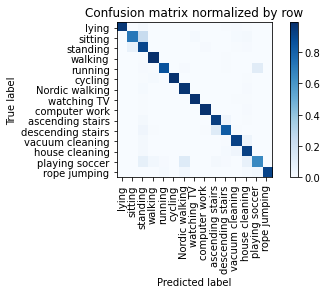

Overall accuracy: 0.918

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.991      0.979      0.985      0.130        584|	 house cleaning: 0.010,	standing: 0.007,	
          walking       0.975      0.989      0.982      0.106        476|	 descending stairs: 0.004,	standing: 0.004,	
            lying       0.997      0.954      0.975      0.087        390|	 standing: 0.021,	vacuum cleaning: 0.010,	
         standing       0.698      0.903      0.787      0.083        373|	 sitting: 0.072,	house cleaning: 0.011,	
          sitting       0.905      0.718      0.801      0.083        372|	 standing: 0.237,	house cleaning: 0.019,	
   house cleaning       0.864      0.925      0.893      0.080        358|	 vacuum cleaning: 0.039,	standing: 0.020,	
   Nordic walking       0.953      0.969      0.961      0.080        358|	 standing: 0.014,	house cleaning: 0.008,	
  vacuum cleaning       0.921      0.923      0.922      0.

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

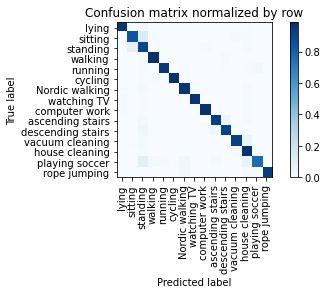

Overall accuracy: 0.942

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.978      0.985      0.131        587|	 house cleaning: 0.009,	lying: 0.009,	
          walking       0.987      0.985      0.986      0.105        472|	 descending stairs: 0.008,	standing: 0.004,	
            lying       0.982      0.957      0.969      0.087        392|	 standing: 0.028,	vacuum cleaning: 0.008,	
         standing       0.761      0.904      0.826      0.084        376|	 sitting: 0.077,	house cleaning: 0.008,	
          sitting       0.906      0.844      0.874      0.082        366|	 standing: 0.131,	house cleaning: 0.014,	
   Nordic walking       0.978      0.967      0.972      0.081        363|	 standing: 0.017,	house cleaning: 0.011,	
   house cleaning       0.872      0.972      0.919      0.079        356|	 vacuum cleaning: 0.014,	standing: 0.014,	
  vacuum cleaning       0.957      0.923      0.940      0.075

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

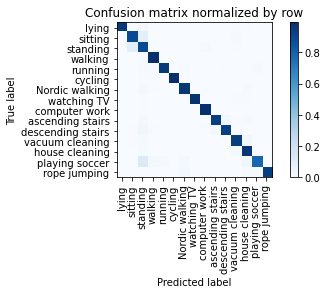

Overall accuracy: 0.951

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.992      0.992      0.132        592|	 standing: 0.007,	house cleaning: 0.002,	
          walking       0.983      0.992      0.987      0.106        474|	 standing: 0.004,	vacuum cleaning: 0.002,	
            lying       1.000      0.957      0.978      0.087        391|	 standing: 0.026,	vacuum cleaning: 0.008,	
         standing       0.777      0.887      0.829      0.083        373|	 sitting: 0.097,	computer work: 0.008,	
          sitting       0.890      0.892      0.891      0.083        371|	 standing: 0.092,	vacuum cleaning: 0.013,	
   Nordic walking       0.983      0.966      0.975      0.080        358|	 standing: 0.017,	house cleaning: 0.008,	
   house cleaning       0.922      0.966      0.943      0.079        353|	 vacuum cleaning: 0.017,	standing: 0.014,	
  vacuum cleaning       0.941      0.938      0.940      0.07

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

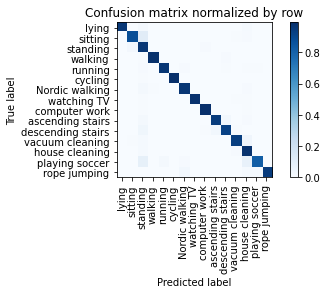

Overall accuracy: 0.956

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.988      0.991      0.131        586|	 house cleaning: 0.007,	standing: 0.005,	
          walking       0.994      0.985      0.989      0.106        475|	 descending stairs: 0.008,	standing: 0.006,	
            lying       1.000      0.959      0.979      0.087        389|	 standing: 0.023,	house cleaning: 0.013,	
         standing       0.787      0.960      0.865      0.083        374|	 sitting: 0.027,	computer work: 0.008,	
          sitting       0.961      0.876      0.917      0.083        370|	 standing: 0.111,	house cleaning: 0.008,	
   Nordic walking       0.986      0.967      0.976      0.081        361|	 standing: 0.017,	house cleaning: 0.008,	
   house cleaning       0.889      0.977      0.931      0.078        351|	 standing: 0.014,	vacuum cleaning: 0.009,	
  vacuum cleaning       0.973      0.935      0.954      0.07

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

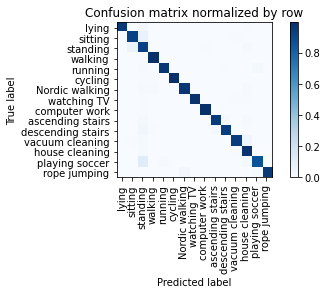

Overall accuracy: 0.961

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.997      0.993      0.995      0.130        584|	 standing: 0.005,	house cleaning: 0.002,	
          walking       0.985      0.992      0.989      0.107        478|	 standing: 0.004,	house cleaning: 0.002,	
            lying       1.000      0.957      0.978      0.088        393|	 standing: 0.031,	house cleaning: 0.008,	
          sitting       0.932      0.922      0.927      0.083        374|	 standing: 0.070,	vacuum cleaning: 0.005,	
         standing       0.802      0.927      0.860      0.082        368|	 sitting: 0.060,	house cleaning: 0.008,	
   Nordic walking       0.994      0.967      0.980      0.081        361|	 house cleaning: 0.011,	standing: 0.011,	
   house cleaning       0.914      0.980      0.946      0.079        356|	 standing: 0.014,	vacuum cleaning: 0.006,	
  vacuum cleaning       0.982      0.936      0.958      0.076

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

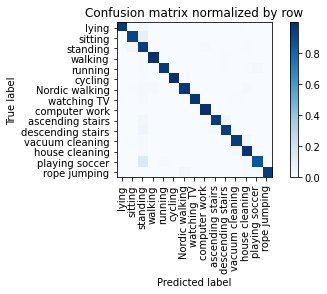

Overall accuracy: 0.963

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.997      0.995      0.132        591|	 house cleaning: 0.002,	standing: 0.002,	
          walking       0.992      0.992      0.992      0.106        475|	 descending stairs: 0.004,	standing: 0.004,	
            lying       0.997      0.956      0.976      0.087        389|	 standing: 0.036,	vacuum cleaning: 0.008,	
         standing       0.799      0.949      0.868      0.083        373|	 sitting: 0.035,	computer work: 0.008,	
          sitting       0.952      0.919      0.935      0.082        369|	 standing: 0.076,	house cleaning: 0.003,	
   Nordic walking       0.994      0.967      0.980      0.080        359|	 house cleaning: 0.011,	walking: 0.008,	
   house cleaning       0.943      0.975      0.959      0.079        356|	 vacuum cleaning: 0.014,	standing: 0.011,	
  vacuum cleaning       0.964      0.950      0.957      0.07

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

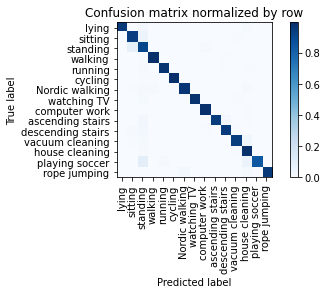

Overall accuracy: 0.961

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.993      0.993      0.129        579|	 house cleaning: 0.005,	sitting: 0.002,	
          walking       0.990      0.992      0.991      0.106        477|	 descending stairs: 0.004,	standing: 0.004,	
            lying       1.000      0.957      0.978      0.088        393|	 standing: 0.028,	house cleaning: 0.015,	
         standing       0.824      0.906      0.863      0.083        373|	 sitting: 0.083,	computer work: 0.008,	
          sitting       0.901      0.935      0.918      0.083        371|	 standing: 0.057,	vacuum cleaning: 0.005,	
   Nordic walking       0.994      0.967      0.980      0.081        361|	 standing: 0.011,	house cleaning: 0.008,	
   house cleaning       0.907      0.986      0.945      0.080        357|	 standing: 0.008,	vacuum cleaning: 0.006,	
  vacuum cleaning       0.981      0.941      0.961      0.07

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

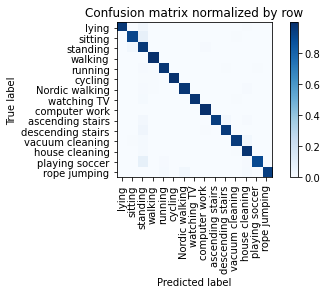

Overall accuracy: 0.967

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.997      0.995      0.132        591|	 house cleaning: 0.002,	sitting: 0.002,	
          walking       0.989      0.996      0.993      0.106        473|	 descending stairs: 0.002,	standing: 0.002,	
            lying       1.000      0.959      0.979      0.087        389|	 standing: 0.033,	house cleaning: 0.005,	
         standing       0.810      0.960      0.879      0.083        373|	 sitting: 0.029,	computer work: 0.008,	
          sitting       0.958      0.914      0.935      0.083        371|	 standing: 0.078,	vacuum cleaning: 0.005,	
   Nordic walking       0.994      0.969      0.982      0.080        360|	 house cleaning: 0.011,	standing: 0.011,	
   house cleaning       0.938      0.980      0.959      0.079        354|	 standing: 0.014,	vacuum cleaning: 0.006,	
  vacuum cleaning       0.982      0.950      0.966      0.07

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

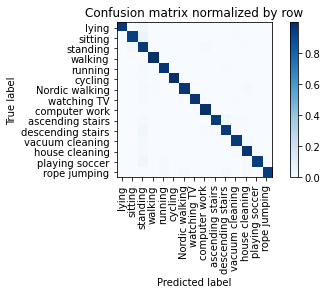

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.997      0.994      0.131        589|	 house cleaning: 0.002,	sitting: 0.002,	
          walking       0.994      0.996      0.995      0.106        475|	 descending stairs: 0.002,	standing: 0.002,	
            lying       1.000      0.959      0.979      0.087        388|	 standing: 0.031,	vacuum cleaning: 0.008,	
         standing       0.838      0.957      0.894      0.083        374|	 sitting: 0.027,	computer work: 0.008,	
          sitting       0.964      0.932      0.948      0.082        369|	 standing: 0.060,	vacuum cleaning: 0.005,	
   Nordic walking       0.997      0.970      0.983      0.081        363|	 house cleaning: 0.011,	standing: 0.011,	
   house cleaning       0.951      0.980      0.966      0.080        357|	 standing: 0.011,	vacuum cleaning: 0.008,	
  vacuum cleaning       0.964      0.956      0.960      0.0

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

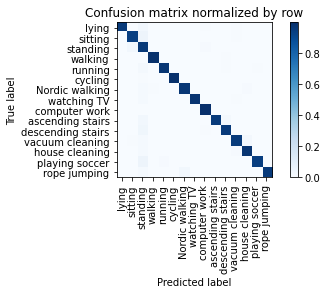

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.987      0.998      0.992      0.131        586|	 standing: 0.002,	rope jumping: 0.000,	
          walking       0.996      0.994      0.995      0.106        476|	 descending stairs: 0.004,	standing: 0.002,	
            lying       1.000      0.959      0.979      0.087        392|	 standing: 0.028,	computer work: 0.008,	
         standing       0.833      0.960      0.892      0.084        375|	 sitting: 0.029,	computer work: 0.008,	
          sitting       0.961      0.940      0.950      0.081        364|	 standing: 0.049,	vacuum cleaning: 0.005,	
   Nordic walking       0.994      0.969      0.982      0.080        360|	 standing: 0.014,	house cleaning: 0.008,	
   house cleaning       0.964      0.977      0.971      0.079        355|	 standing: 0.014,	vacuum cleaning: 0.008,	
  vacuum cleaning       0.976      0.953      0.964      0.076 

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

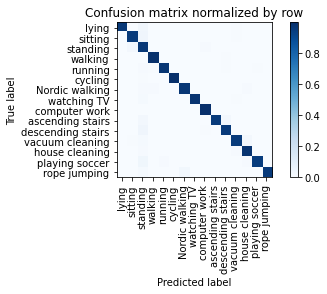

Overall accuracy: 0.972

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.997      0.995      0.131        587|	 house cleaning: 0.002,	sitting: 0.002,	
          walking       0.992      0.992      0.992      0.106        475|	 descending stairs: 0.006,	standing: 0.002,	
            lying       1.000      0.959      0.979      0.087        390|	 standing: 0.033,	vacuum cleaning: 0.005,	
         standing       0.847      0.965      0.902      0.083        372|	 sitting: 0.027,	computer work: 0.008,	
          sitting       0.962      0.951      0.956      0.082        368|	 standing: 0.041,	vacuum cleaning: 0.005,	
   Nordic walking       0.994      0.967      0.981      0.081        365|	 house cleaning: 0.011,	standing: 0.011,	
   house cleaning       0.956      0.980      0.968      0.079        355|	 standing: 0.011,	vacuum cleaning: 0.008,	
  vacuum cleaning       0.976      0.953      0.964      0.0

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

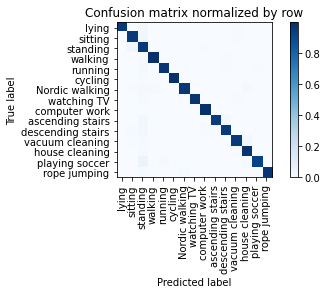

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.995      0.997      0.996      0.131        589|	 house cleaning: 0.002,	sitting: 0.002,	
          walking       0.992      0.989      0.990      0.106        473|	 descending stairs: 0.006,	standing: 0.004,	
            lying       1.000      0.961      0.980      0.087        388|	 standing: 0.031,	vacuum cleaning: 0.005,	
         standing       0.848      0.957      0.899      0.083        372|	 sitting: 0.035,	computer work: 0.005,	
          sitting       0.947      0.957      0.952      0.083        371|	 standing: 0.035,	vacuum cleaning: 0.005,	
   Nordic walking       0.997      0.967      0.982      0.081        362|	 standing: 0.011,	house cleaning: 0.008,	
   house cleaning       0.951      0.983      0.967      0.080        358|	 standing: 0.011,	vacuum cleaning: 0.006,	
  vacuum cleaning       0.979      0.953      0.966      0.0

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

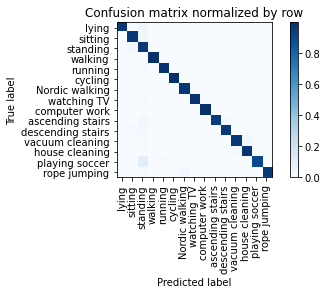

Overall accuracy: 0.972

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.997      0.997      0.997      0.132        591|	 house cleaning: 0.002,	sitting: 0.002,	
          walking       0.994      0.996      0.995      0.106        476|	 descending stairs: 0.002,	standing: 0.002,	
            lying       1.000      0.959      0.979      0.086        387|	 standing: 0.036,	vacuum cleaning: 0.005,	
         standing       0.841      0.965      0.899      0.083        373|	 sitting: 0.027,	house cleaning: 0.005,	
          sitting       0.959      0.957      0.958      0.082        369|	 standing: 0.035,	vacuum cleaning: 0.005,	
   Nordic walking       0.994      0.970      0.982      0.081        361|	 house cleaning: 0.011,	standing: 0.011,	
   house cleaning       0.953      0.977      0.965      0.079        355|	 vacuum cleaning: 0.014,	standing: 0.008,	
  vacuum cleaning       0.970      0.959      0.965      0.

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

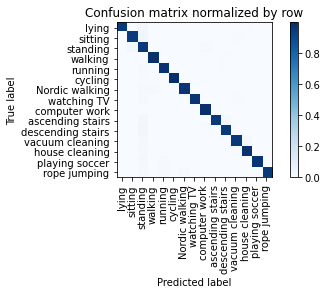

Overall accuracy: 0.975

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.998      0.996      0.131        589|	 sitting: 0.002,	rope jumping: 0.000,	
          walking       0.990      0.994      0.992      0.106        476|	 descending stairs: 0.004,	standing: 0.002,	
            lying       1.000      0.961      0.980      0.087        389|	 standing: 0.031,	house cleaning: 0.005,	
         standing       0.852      0.965      0.905      0.084        376|	 sitting: 0.024,	computer work: 0.008,	
          sitting       0.967      0.951      0.959      0.083        370|	 standing: 0.041,	vacuum cleaning: 0.005,	
   Nordic walking       0.997      0.973      0.985      0.081        364|	 standing: 0.014,	walking: 0.011,	
   house cleaning       0.972      0.983      0.978      0.079        354|	 standing: 0.011,	vacuum cleaning: 0.006,	
  vacuum cleaning       0.982      0.961      0.971      0.075        

unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

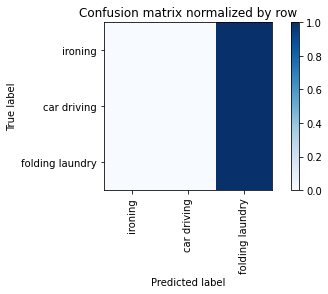

Overall accuracy: 0.253

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       2330|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.253      1.000      0.404      0.253        973|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        537|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.253      0.102        1.0       3840|	      

{'accuracy': 0.25338541666666664, 'precision': 0.08446180555555555, 'recall': 0.3333333333333333, 'f1': 0.13477387630722348}
============== Overall Unseen Classes Performance ==============


accuracy     0.393465
precision    0.484704
recall       0.445228
f1           0.345126
dtype: float64

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'],weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=True, loss_alpha=0.0001)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)
    
    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],   phase='unseen', loss_alpha=0.0001)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
